In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"..\Data\Data\news_content_final.csv")
print(df.shape)
df.head()

(26227, 6)


,title,text,type,tokenized_headline,tokenized_content,valid_score
0,Muslims BUSTED They Stole Millions In Govt Ben...,Print They should pay all the back all the mon...,bias,muslims,somalis,0
1,Re Why Did Attorney General Loretta Lynch Plea...,Why Did Attorney General Loretta Lynch Plead T...,bias,loretta lynch,loretta lynch barracuda brigade iran loretta l...,0
2,BREAKING Weiner Cooperating With FBI On Hillar...,Red State Fox News Sunday reported this mornin...,bias,weiner fbi hillary email investigation,red state fox news anthony weiner fbi hillary ...,0
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias,donald j. trump,kayla mueller isis carl mueller donald trump,0
4,FANTASTIC! TRUMPS 7 POINT PLAN To Reform Healt...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,notokes,house senate obamacare obamacare democrats oba...,0


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
from sklearn.metrics import log_loss

In [4]:
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')
sns.set_context('notebook')
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tori\AppData\Roaming\nltk_data...


Numpy version: 1.16.5
Pandas version: 0.25.1
Seaborn version: 0.9.0


[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26227 entries, 0 to 26226
Data columns (total 6 columns):
title                 26226 non-null object
text                  26227 non-null object
type                  26227 non-null object
tokenized_headline    26227 non-null object
tokenized_content     26227 non-null object
valid_score           26227 non-null int64
dtypes: int64(1), object(5)
memory usage: 1.2+ MB


In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [8]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', df['text'].shape)
train_cleaned = cleanup_text(df['text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (26227,)
Processed 1000 out of 26227 documents.
Processed 2000 out of 26227 documents.
Processed 3000 out of 26227 documents.
Processed 4000 out of 26227 documents.
Processed 5000 out of 26227 documents.
Processed 6000 out of 26227 documents.
Processed 7000 out of 26227 documents.
Processed 8000 out of 26227 documents.
Processed 9000 out of 26227 documents.
Processed 10000 out of 26227 documents.
Processed 11000 out of 26227 documents.
Processed 12000 out of 26227 documents.
Processed 13000 out of 26227 documents.
Processed 14000 out of 26227 documents.
Processed 15000 out of 26227 documents.
Processed 16000 out of 26227 documents.
Processed 17000 out of 26227 documents.
Processed 18000 out of 26227 documents.
Processed 19000 out of 26227 documents.
Processed 20000 out of 26227 documents.
Processed 21000 out of 26227 documents.
Processed 22000 out of 26227 documents.
Processed 23000 out of 26227 documents.
Processed 24000 out of 26227 documents.
Processed

In [9]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
# train_vec = [doc.vector for doc in nlp.pipe(train_cleaned, batch_size=500)]
train_vec = np.array(train_vec)

end = time()

Parsing documents...


In [10]:
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(df['text'][0]))
print('Number of words in second document: ', len(df['text'][1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Total time passed parsing documents: 1102.6239161491394 seconds
Total number of documents parsed: 26227
Number of words in first document:  498
Number of words in second document:  1761
Size of vector embeddings:  96
Shape of vectors embeddings matrix:  (26227, 96)


In [11]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [12]:
train_cleaned_word2vec = cleanup_text_word2vec(df['text'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 1000 out of 26227 documents
Processed 2000 out of 26227 documents
Processed 3000 out of 26227 documents
Processed 4000 out of 26227 documents
Processed 5000 out of 26227 documents
Processed 6000 out of 26227 documents
Processed 7000 out of 26227 documents
Processed 8000 out of 26227 documents
Processed 9000 out of 26227 documents
Processed 10000 out of 26227 documents
Processed 11000 out of 26227 documents
Processed 12000 out of 26227 documents
Processed 13000 out of 26227 documents
Processed 14000 out of 26227 documents
Processed 15000 out of 26227 documents
Processed 16000 out of 26227 documents
Processed 17000 out of 26227 documents
Processed 18000 out of 26227 documents
Processed 19000 out of 26227 documents
Processed 20000 out of 26227 documents
Processed 21000 out of 26227 documents
Processed 22000 out of 26227 documents
Processed 23000 out of 26227 documents
Processed 24000 out of 26227 documents
Processed 25000 out of 26227 documents
Processed 26000 out of 26227 docum

In [13]:
df['all_articles'] = [str(art) for art in df.text]
df.head()

,title,text,type,tokenized_headline,tokenized_content,valid_score,all_articles
0,Muslims BUSTED They Stole Millions In Govt Ben...,Print They should pay all the back all the mon...,bias,muslims,somalis,0,Print They should pay all the back all the mon...
1,Re Why Did Attorney General Loretta Lynch Plea...,Why Did Attorney General Loretta Lynch Plead T...,bias,loretta lynch,loretta lynch barracuda brigade iran loretta l...,0,Why Did Attorney General Loretta Lynch Plead T...
2,BREAKING Weiner Cooperating With FBI On Hillar...,Red State Fox News Sunday reported this mornin...,bias,weiner fbi hillary email investigation,red state fox news anthony weiner fbi hillary ...,0,Red State Fox News Sunday reported this mornin...
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias,donald j. trump,kayla mueller isis carl mueller donald trump,0,Email Kayla Mueller was a prisoner and torture...
4,FANTASTIC! TRUMPS 7 POINT PLAN To Reform Healt...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,notokes,house senate obamacare obamacare democrats oba...,0,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf #magical gradient computation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.corpus import stopwords

In [15]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tori\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [16]:
real_text = ' '.join(df[df['valid_score'] == 1]['all_articles'])
fake_text = ' '.join(df[df['valid_score'] == 0]['all_articles'])
fake_words = [word for word in nltk.tokenize.word_tokenize(fake_text) if word not in stopwords.words('english') and len(word) > 3]
real_words = [word for word in nltk.tokenize.word_tokenize(real_text) if word not in stopwords.words('english') and len(word) > 3]

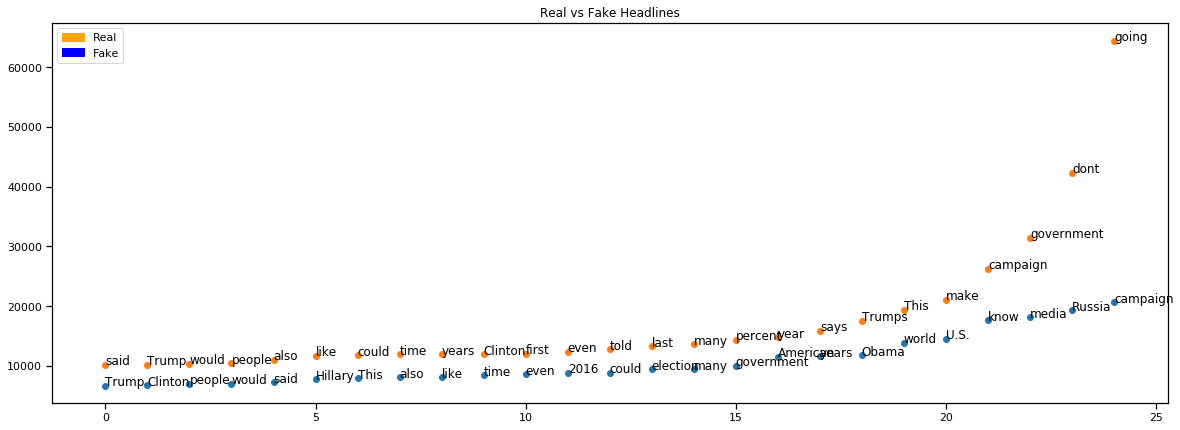

In [17]:
common_fake = nltk.FreqDist(fake_words).most_common(25)
common_real =nltk.FreqDist(real_words).most_common(25)
fake_ranks = []
fake_counts = []
real_ranks = []
real_counts = []

for ii, word in enumerate(reversed(common_fake)):
    fake_ranks.append(ii)
    fake_counts.append(word[1])

for ii, word in enumerate(reversed(common_real)):
    real_ranks.append(ii)
    real_counts.append(word[1])

plt.figure(figsize=(20, 7))

plt.scatter(fake_ranks, fake_counts)

for labels, fake_rank, fake_count in zip(common_fake, fake_ranks, fake_counts):
    plt.annotate(
        labels[0],
        xy = (fake_rank, fake_count)
    )

plt.scatter(real_ranks, real_counts)
plt.title('Real vs Fake Headlines')

for labels, real_rank, real_count in zip(common_real, real_ranks, real_counts):
    plt.annotate(
        labels[0],
        xy = (real_rank, real_count)
    )
    
real_patch = mpatches.Patch(color='orange', label='Real')
fake_patch = mpatches.Patch(color='blue', label='Fake')
plt.legend(handles=[real_patch, fake_patch])

plt.show()

In [18]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['all_articles'] = df['all_articles'].apply(clean_text)
df['all_articles'] = df['all_articles'].str.replace('\d+', '')

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 600
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['all_articles'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 185536 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(df['all_articles'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (26227, 600)


In [23]:
Y = pd.get_dummies(df['valid_score']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (26227, 2)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(23604, 600) (23604, 2)
(2623, 600) (2623, 2)


In [25]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 5,042,370
Trainable params: 5,042,370
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
epochs = 15
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23604 samples, validate on 2623 samples
Epoch 1/15


11776/23604 [=============>................] - ETA: 24:38 - loss: 0.6950 - accuracy: 0.500 - ETA: 14:20 - loss: 0.6952 - accuracy: 0.492 - ETA: 10:50 - loss: 0.6929 - accuracy: 0.546 - ETA: 9:02 - loss: 0.6923 - accuracy: 0.546 - ETA: 8:01 - loss: 0.6921 - accuracy: 0.55 - ETA: 7:17 - loss: 0.6934 - accuracy: 0.52 - ETA: 6:46 - loss: 0.6926 - accuracy: 0.53 - ETA: 6:22 - loss: 0.6915 - accuracy: 0.54 - ETA: 6:04 - loss: 0.6908 - accuracy: 0.55 - ETA: 5:51 - loss: 0.6896 - accuracy: 0.55 - ETA: 5:37 - loss: 0.6891 - accuracy: 0.55 - ETA: 5:27 - loss: 0.6883 - accuracy: 0.56 - ETA: 5:19 - loss: 0.6871 - accuracy: 0.56 - ETA: 5:11 - loss: 0.6868 - accuracy: 0.56 - ETA: 5:04 - loss: 0.6850 - accuracy: 0.57 - ETA: 4:59 - loss: 0.6831 - accuracy: 0.57 - ETA: 4:53 - loss: 0.6815 - accuracy: 0.58 - ETA: 4:48 - loss: 0.6799 - accuracy: 0.58 - ETA: 4:44 - loss: 0.6792 - accuracy: 0.58 - ETA: 4:40 - loss: 0.6803 - accuracy: 0.57 - ETA: 4:36 - loss: 0.6821 - accuracy: 0.57 - ETA: 4:32 - loss: 0.68

Epoch 2/15


11840/23604 [==============>...............] - ETA: 3:45 - loss: 0.1138 - accuracy: 0.95 - ETA: 3:48 - loss: 0.1226 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1091 - accuracy: 0.95 - ETA: 3:49 - loss: 0.0990 - accuracy: 0.96 - ETA: 3:47 - loss: 0.1019 - accuracy: 0.96 - ETA: 3:46 - loss: 0.1036 - accuracy: 0.96 - ETA: 3:46 - loss: 0.1102 - accuracy: 0.96 - ETA: 3:46 - loss: 0.1037 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1017 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1112 - accuracy: 0.96 - ETA: 3:44 - loss: 0.1122 - accuracy: 0.96 - ETA: 3:43 - loss: 0.1108 - accuracy: 0.96 - ETA: 3:43 - loss: 0.1103 - accuracy: 0.96 - ETA: 3:42 - loss: 0.1130 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1103 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1110 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1098 - accuracy: 0.96 - ETA: 3:39 - loss: 0.1106 - accuracy: 0.96 - ETA: 3:39 - loss: 0.1210 - accuracy: 0.96 - ETA: 3:38 - loss: 0.1232 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1232 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1211 - ac

11904/23604 [==============>...............] - ETA: 3:43 - loss: 0.0423 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0432 - accuracy: 0.99 - ETA: 3:51 - loss: 0.0342 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0366 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0444 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0496 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0529 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0506 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0504 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0575 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0549 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0531 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0518 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0562 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0545 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0537 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0540 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0550 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0521 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0505 - ac

23604/23604 [==============================] - ETA: 1:54 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0629 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0631 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0629 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0629 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0631 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0629 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0630 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0630 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0635 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0636 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0635 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0633 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0631 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0633 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0633 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0632 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0632 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0636 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0634 - ac

11904/23604 [==============>...............] - ETA: 3:41 - loss: 0.0151 - accuracy: 1.00 - ETA: 3:50 - loss: 0.0154 - accuracy: 1.00 - ETA: 3:49 - loss: 0.0148 - accuracy: 1.00 - ETA: 3:51 - loss: 0.0186 - accuracy: 0.99 - ETA: 3:50 - loss: 0.0183 - accuracy: 0.99 - ETA: 3:48 - loss: 0.0222 - accuracy: 0.99 - ETA: 3:48 - loss: 0.0290 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0311 - accuracy: 0.99 - ETA: 3:47 - loss: 0.0389 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0354 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0326 - accuracy: 0.99 - ETA: 3:45 - loss: 0.0335 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0326 - accuracy: 0.99 - ETA: 3:44 - loss: 0.0338 - accuracy: 0.99 - ETA: 3:43 - loss: 0.0338 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0325 - accuracy: 0.99 - ETA: 3:42 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0399 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0388 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0373 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0369 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0361 - ac

In [27]:
df['all_articles'] = [str(art) for art in df.tokenized_content]
df.head()

,title,text,type,tokenized_headline,tokenized_content,valid_score,all_articles
0,Muslims BUSTED They Stole Millions In Govt Ben...,Print They should pay all the back all the mon...,bias,muslims,somalis,0,somalis
1,Re Why Did Attorney General Loretta Lynch Plea...,Why Did Attorney General Loretta Lynch Plead T...,bias,loretta lynch,loretta lynch barracuda brigade iran loretta l...,0,loretta lynch barracuda brigade iran loretta l...
2,BREAKING Weiner Cooperating With FBI On Hillar...,Red State Fox News Sunday reported this mornin...,bias,weiner fbi hillary email investigation,red state fox news anthony weiner fbi hillary ...,0,red state fox news anthony weiner fbi hillary ...
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias,donald j. trump,kayla mueller isis carl mueller donald trump,0,kayla mueller isis carl mueller donald trump
4,FANTASTIC! TRUMPS 7 POINT PLAN To Reform Healt...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,notokes,house senate obamacare obamacare democrats oba...,0,house senate obamacare obamacare democrats oba...


In [28]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['all_articles'] = df['all_articles'].apply(clean_text)
df['all_articles'] = df['all_articles'].str.replace('\d+', '')

In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 600
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['all_articles'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 86641 unique tokens.


In [31]:
X = tokenizer.texts_to_sequences(df['all_articles'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (26227, 600)


In [32]:
Y = pd.get_dummies(df['valid_score']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (26227, 2)


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(23604, 600) (23604, 2)
(2623, 600) (2623, 2)


In [34]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 5,042,370
Trainable params: 5,042,370
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
epochs = 15
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23604 samples, validate on 2623 samples
Epoch 1/15


 5888/23604 [======>.......................] - ETA: 24:10 - loss: 0.6949 - accuracy: 0.468 - ETA: 16:06 - loss: 0.6944 - accuracy: 0.437 - ETA: 13:27 - loss: 0.6911 - accuracy: 0.541 - ETA: 11:58 - loss: 0.6908 - accuracy: 0.570 - ETA: 11:05 - loss: 0.6886 - accuracy: 0.612 - ETA: 10:30 - loss: 0.6887 - accuracy: 0.599 - ETA: 10:06 - loss: 0.6891 - accuracy: 0.580 - ETA: 9:46 - loss: 0.6885 - accuracy: 0.578 - ETA: 9:32 - loss: 0.6862 - accuracy: 0.59 - ETA: 9:20 - loss: 0.6853 - accuracy: 0.60 - ETA: 9:10 - loss: 0.6836 - accuracy: 0.61 - ETA: 9:01 - loss: 0.6824 - accuracy: 0.61 - ETA: 8:54 - loss: 0.6818 - accuracy: 0.62 - ETA: 8:45 - loss: 0.6785 - accuracy: 0.63 - ETA: 8:39 - loss: 0.6757 - accuracy: 0.63 - ETA: 8:35 - loss: 0.6717 - accuracy: 0.65 - ETA: 8:31 - loss: 0.6663 - accuracy: 0.65 - ETA: 8:26 - loss: 0.6666 - accuracy: 0.65 - ETA: 8:22 - loss: 0.6691 - accuracy: 0.64 - ETA: 8:19 - loss: 0.6657 - accuracy: 0.64 - ETA: 8:15 - loss: 0.6618 - accuracy: 0.64 - ETA: 8:12 - lo

17792/23604 [=====================>........] - ETA: 3:49 - loss: 0.3665 - accuracy: 0.83 - ETA: 3:48 - loss: 0.3662 - accuracy: 0.83 - ETA: 3:48 - loss: 0.3660 - accuracy: 0.83 - ETA: 3:47 - loss: 0.3655 - accuracy: 0.83 - ETA: 3:47 - loss: 0.3648 - accuracy: 0.83 - ETA: 3:46 - loss: 0.3647 - accuracy: 0.83 - ETA: 3:45 - loss: 0.3644 - accuracy: 0.83 - ETA: 3:45 - loss: 0.3641 - accuracy: 0.83 - ETA: 3:44 - loss: 0.3639 - accuracy: 0.83 - ETA: 3:43 - loss: 0.3641 - accuracy: 0.83 - ETA: 3:43 - loss: 0.3635 - accuracy: 0.83 - ETA: 3:42 - loss: 0.3630 - accuracy: 0.83 - ETA: 3:42 - loss: 0.3634 - accuracy: 0.83 - ETA: 3:41 - loss: 0.3628 - accuracy: 0.83 - ETA: 3:40 - loss: 0.3623 - accuracy: 0.84 - ETA: 3:40 - loss: 0.3626 - accuracy: 0.84 - ETA: 3:39 - loss: 0.3627 - accuracy: 0.84 - ETA: 3:38 - loss: 0.3621 - accuracy: 0.84 - ETA: 3:38 - loss: 0.3618 - accuracy: 0.84 - ETA: 3:37 - loss: 0.3615 - accuracy: 0.84 - ETA: 3:37 - loss: 0.3617 - accuracy: 0.84 - ETA: 3:36 - loss: 0.3614 - ac

23604/23604 [==============================] - ETA: 1:53 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:52 - loss: 0.3360 - accuracy: 0.85 - ETA: 1:51 - loss: 0.3360 - accuracy: 0.85 - ETA: 1:51 - loss: 0.3360 - accuracy: 0.85 - ETA: 1:50 - loss: 0.3358 - accuracy: 0.85 - ETA: 1:49 - loss: 0.3354 - accuracy: 0.85 - ETA: 1:49 - loss: 0.3356 - accuracy: 0.85 - ETA: 1:48 - loss: 0.3354 - accuracy: 0.85 - ETA: 1:48 - loss: 0.3353 - accuracy: 0.85 - ETA: 1:47 - loss: 0.3350 - accuracy: 0.85 - ETA: 1:46 - loss: 0.3347 - accuracy: 0.85 - ETA: 1:46 - loss: 0.3346 - accuracy: 0.85 - ETA: 1:45 - loss: 0.3344 - accuracy: 0.85 - ETA: 1:44 - loss: 0.3340 - accuracy: 0.85 - ETA: 1:44 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:43 - loss: 0.3335 - accuracy: 0.85 - ETA: 1:42 - loss: 0.3335 - accuracy: 0.85 - ETA: 1:42 - loss: 0.3331 - accuracy: 0.85 - ETA: 1:41 - loss: 0.3329 - accuracy: 0.85 - ETA: 1:41 - loss: 0.3329 - accuracy: 0.85 - ETA: 1:40 - loss: 0.3325 - accuracy: 0.85 - ETA: 1:39 - loss: 0.3326 - ac

 5952/23604 [======>.......................] - ETA: 7:39 - loss: 0.1094 - accuracy: 0.96 - ETA: 7:54 - loss: 0.0808 - accuracy: 0.98 - ETA: 7:46 - loss: 0.0718 - accuracy: 0.98 - ETA: 7:40 - loss: 0.0788 - accuracy: 0.97 - ETA: 7:34 - loss: 0.0863 - accuracy: 0.97 - ETA: 7:39 - loss: 0.1029 - accuracy: 0.95 - ETA: 7:38 - loss: 0.0971 - accuracy: 0.96 - ETA: 7:37 - loss: 0.1039 - accuracy: 0.96 - ETA: 7:37 - loss: 0.1031 - accuracy: 0.96 - ETA: 7:35 - loss: 0.1032 - accuracy: 0.95 - ETA: 7:36 - loss: 0.1044 - accuracy: 0.96 - ETA: 7:35 - loss: 0.0980 - accuracy: 0.96 - ETA: 7:34 - loss: 0.1029 - accuracy: 0.96 - ETA: 7:35 - loss: 0.1109 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1149 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1149 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1142 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1222 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1171 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1202 - accuracy: 0.95 - ETA: 7:29 - loss: 0.1248 - accuracy: 0.95 - ETA: 7:28 - loss: 0.1290 - ac

17856/23604 [=====================>........] - ETA: 3:47 - loss: 0.1361 - accuracy: 0.95 - ETA: 3:46 - loss: 0.1361 - accuracy: 0.95 - ETA: 3:45 - loss: 0.1360 - accuracy: 0.95 - ETA: 3:45 - loss: 0.1362 - accuracy: 0.95 - ETA: 3:44 - loss: 0.1362 - accuracy: 0.95 - ETA: 3:44 - loss: 0.1360 - accuracy: 0.95 - ETA: 3:43 - loss: 0.1364 - accuracy: 0.95 - ETA: 3:42 - loss: 0.1370 - accuracy: 0.95 - ETA: 3:42 - loss: 0.1367 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1366 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1367 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1371 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1373 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1374 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1373 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1375 - accuracy: 0.94 - ETA: 3:36 - loss: 0.1374 - accuracy: 0.94 - ETA: 3:35 - loss: 0.1371 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1369 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1368 - ac

23604/23604 [==============================] - ETA: 1:51 - loss: 0.1424 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1422 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1421 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1421 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1419 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1419 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:45 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:45 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:44 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:43 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:43 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:42 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1417 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1419 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1417 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1415 - ac

 5952/23604 [======>.......................] - ETA: 7:38 - loss: 0.0280 - accuracy: 1.00 - ETA: 7:35 - loss: 0.0927 - accuracy: 0.95 - ETA: 7:35 - loss: 0.0912 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1265 - accuracy: 0.92 - ETA: 7:37 - loss: 0.1262 - accuracy: 0.92 - ETA: 7:36 - loss: 0.1099 - accuracy: 0.93 - ETA: 7:37 - loss: 0.1268 - accuracy: 0.93 - ETA: 7:37 - loss: 0.1182 - accuracy: 0.94 - ETA: 7:36 - loss: 0.1191 - accuracy: 0.94 - ETA: 7:35 - loss: 0.1135 - accuracy: 0.94 - ETA: 7:34 - loss: 0.1135 - accuracy: 0.94 - ETA: 7:33 - loss: 0.1245 - accuracy: 0.94 - ETA: 7:31 - loss: 0.1201 - accuracy: 0.94 - ETA: 7:30 - loss: 0.1132 - accuracy: 0.95 - ETA: 7:29 - loss: 0.1080 - accuracy: 0.95 - ETA: 7:28 - loss: 0.1030 - accuracy: 0.95 - ETA: 7:28 - loss: 0.0992 - accuracy: 0.95 - ETA: 7:28 - loss: 0.1070 - accuracy: 0.95 - ETA: 7:26 - loss: 0.1103 - accuracy: 0.95 - ETA: 7:25 - loss: 0.1054 - accuracy: 0.96 - ETA: 7:25 - loss: 0.1017 - accuracy: 0.96 - ETA: 7:24 - loss: 0.1034 - ac

17856/23604 [=====================>........] - ETA: 3:46 - loss: 0.0732 - accuracy: 0.97 - ETA: 3:45 - loss: 0.0732 - accuracy: 0.97 - ETA: 3:45 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0737 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0737 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0741 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0743 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0741 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0740 - accuracy: 0.97 - ETA: 3:33 - loss: 0.0742 - accuracy: 0.97 - ETA: 3:33 - loss: 0.0742 - ac

23604/23604 [==============================] - ETA: 1:50 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:48 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:47 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:47 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:46 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:45 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:45 - loss: 0.0778 - accuracy: 0.97 - ETA: 1:44 - loss: 0.0780 - accuracy: 0.97 - ETA: 1:44 - loss: 0.0779 - accuracy: 0.97 - ETA: 1:43 - loss: 0.0781 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0782 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0782 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0780 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0781 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0780 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0780 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0779 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0779 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0778 - ac

 5952/23604 [======>.......................] - ETA: 7:55 - loss: 0.0671 - accuracy: 0.96 - ETA: 7:40 - loss: 0.0454 - accuracy: 0.98 - ETA: 7:40 - loss: 0.0436 - accuracy: 0.97 - ETA: 7:38 - loss: 0.0613 - accuracy: 0.97 - ETA: 7:39 - loss: 0.0709 - accuracy: 0.96 - ETA: 7:36 - loss: 0.0617 - accuracy: 0.97 - ETA: 7:35 - loss: 0.0615 - accuracy: 0.97 - ETA: 7:33 - loss: 0.0603 - accuracy: 0.97 - ETA: 7:32 - loss: 0.0548 - accuracy: 0.97 - ETA: 7:32 - loss: 0.0515 - accuracy: 0.97 - ETA: 7:32 - loss: 0.0477 - accuracy: 0.98 - ETA: 7:32 - loss: 0.0534 - accuracy: 0.97 - ETA: 7:29 - loss: 0.0507 - accuracy: 0.98 - ETA: 7:28 - loss: 0.0478 - accuracy: 0.98 - ETA: 7:27 - loss: 0.0464 - accuracy: 0.98 - ETA: 7:26 - loss: 0.0490 - accuracy: 0.98 - ETA: 7:27 - loss: 0.0467 - accuracy: 0.98 - ETA: 7:26 - loss: 0.0452 - accuracy: 0.98 - ETA: 7:25 - loss: 0.0444 - accuracy: 0.98 - ETA: 7:25 - loss: 0.0429 - accuracy: 0.98 - ETA: 7:25 - loss: 0.0455 - accuracy: 0.98 - ETA: 7:26 - loss: 0.0451 - ac

17856/23604 [=====================>........] - ETA: 3:46 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0448 - accuracy: 0.98 - ETA: 3:44 - loss: 0.0450 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0448 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0447 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0446 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0445 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0445 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0444 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0443 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0446 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0452 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0451 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0450 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0451 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0451 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0452 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0451 - ac

23604/23604 [==============================] - ETA: 1:50 - loss: 0.0469 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0468 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0467 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0464 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0466 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0466 - ac

In [39]:
df['all_articles'] = [str(art) for art in df.title]
df.head()

,title,text,type,tokenized_headline,tokenized_content,valid_score,all_articles
0,Muslims BUSTED They Stole Millions In Govt Ben...,Print They should pay all the back all the mon...,bias,muslims,somalis,0,Muslims BUSTED They Stole Millions In Govt Ben...
1,Re Why Did Attorney General Loretta Lynch Plea...,Why Did Attorney General Loretta Lynch Plead T...,bias,loretta lynch,loretta lynch barracuda brigade iran loretta l...,0,Re Why Did Attorney General Loretta Lynch Plea...
2,BREAKING Weiner Cooperating With FBI On Hillar...,Red State Fox News Sunday reported this mornin...,bias,weiner fbi hillary email investigation,red state fox news anthony weiner fbi hillary ...,0,BREAKING Weiner Cooperating With FBI On Hillar...
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,bias,donald j. trump,kayla mueller isis carl mueller donald trump,0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...
4,FANTASTIC! TRUMPS 7 POINT PLAN To Reform Healt...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias,notokes,house senate obamacare obamacare democrats oba...,0,FANTASTIC! TRUMPS 7 POINT PLAN To Reform Healt...


In [40]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['all_articles'] = df['all_articles'].apply(clean_text)
df['all_articles'] = df['all_articles'].str.replace('\d+', '')

In [41]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 600
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['all_articles'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 25130 unique tokens.


In [42]:
X = tokenizer.texts_to_sequences(df['all_articles'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (26227, 600)


In [43]:
Y = pd.get_dummies(df['valid_score']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (26227, 2)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(23604, 600) (23604, 2)
(2623, 600) (2623, 2)


In [45]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 600, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 5,042,370
Trainable params: 5,042,370
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
epochs = 15
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23604 samples, validate on 2623 samples
Epoch 1/15


 5888/23604 [======>.......................] - ETA: 37:30 - loss: 0.6957 - accuracy: 0.343 - ETA: 22:32 - loss: 0.6917 - accuracy: 0.500 - ETA: 17:28 - loss: 0.6930 - accuracy: 0.489 - ETA: 15:00 - loss: 0.6917 - accuracy: 0.515 - ETA: 13:30 - loss: 0.6900 - accuracy: 0.525 - ETA: 12:30 - loss: 0.6895 - accuracy: 0.526 - ETA: 11:47 - loss: 0.6933 - accuracy: 0.500 - ETA: 11:13 - loss: 0.6945 - accuracy: 0.492 - ETA: 10:48 - loss: 0.6922 - accuracy: 0.510 - ETA: 10:28 - loss: 0.6920 - accuracy: 0.512 - ETA: 10:11 - loss: 0.6907 - accuracy: 0.519 - ETA: 9:57 - loss: 0.6896 - accuracy: 0.526 - ETA: 9:45 - loss: 0.6890 - accuracy: 0.52 - ETA: 9:35 - loss: 0.6901 - accuracy: 0.52 - ETA: 9:26 - loss: 0.6900 - accuracy: 0.52 - ETA: 9:17 - loss: 0.6891 - accuracy: 0.52 - ETA: 9:10 - loss: 0.6888 - accuracy: 0.52 - ETA: 9:04 - loss: 0.6883 - accuracy: 0.52 - ETA: 8:58 - loss: 0.6871 - accuracy: 0.53 - ETA: 8:54 - loss: 0.6869 - accuracy: 0.53 - ETA: 8:50 - loss: 0.6869 - accuracy: 0.53 - ETA: 8

17792/23604 [=====================>........] - ETA: 3:50 - loss: 0.5486 - accuracy: 0.70 - ETA: 3:50 - loss: 0.5481 - accuracy: 0.70 - ETA: 3:49 - loss: 0.5481 - accuracy: 0.70 - ETA: 3:48 - loss: 0.5475 - accuracy: 0.70 - ETA: 3:48 - loss: 0.5472 - accuracy: 0.70 - ETA: 3:47 - loss: 0.5475 - accuracy: 0.70 - ETA: 3:46 - loss: 0.5477 - accuracy: 0.70 - ETA: 3:46 - loss: 0.5472 - accuracy: 0.70 - ETA: 3:45 - loss: 0.5470 - accuracy: 0.70 - ETA: 3:44 - loss: 0.5467 - accuracy: 0.70 - ETA: 3:44 - loss: 0.5464 - accuracy: 0.70 - ETA: 3:43 - loss: 0.5461 - accuracy: 0.70 - ETA: 3:43 - loss: 0.5460 - accuracy: 0.70 - ETA: 3:42 - loss: 0.5455 - accuracy: 0.70 - ETA: 3:41 - loss: 0.5450 - accuracy: 0.70 - ETA: 3:41 - loss: 0.5451 - accuracy: 0.70 - ETA: 3:40 - loss: 0.5447 - accuracy: 0.70 - ETA: 3:39 - loss: 0.5443 - accuracy: 0.70 - ETA: 3:39 - loss: 0.5445 - accuracy: 0.70 - ETA: 3:38 - loss: 0.5442 - accuracy: 0.70 - ETA: 3:38 - loss: 0.5439 - accuracy: 0.70 - ETA: 3:37 - loss: 0.5436 - ac

23604/23604 [==============================] - ETA: 1:53 - loss: 0.5352 - accuracy: 0.72 - ETA: 1:52 - loss: 0.5356 - accuracy: 0.72 - ETA: 1:52 - loss: 0.5359 - accuracy: 0.72 - ETA: 1:51 - loss: 0.5362 - accuracy: 0.72 - ETA: 1:50 - loss: 0.5366 - accuracy: 0.72 - ETA: 1:50 - loss: 0.5368 - accuracy: 0.72 - ETA: 1:49 - loss: 0.5367 - accuracy: 0.72 - ETA: 1:48 - loss: 0.5366 - accuracy: 0.72 - ETA: 1:48 - loss: 0.5366 - accuracy: 0.72 - ETA: 1:47 - loss: 0.5367 - accuracy: 0.72 - ETA: 1:46 - loss: 0.5369 - accuracy: 0.72 - ETA: 1:46 - loss: 0.5370 - accuracy: 0.72 - ETA: 1:45 - loss: 0.5368 - accuracy: 0.72 - ETA: 1:45 - loss: 0.5372 - accuracy: 0.72 - ETA: 1:44 - loss: 0.5374 - accuracy: 0.72 - ETA: 1:43 - loss: 0.5376 - accuracy: 0.72 - ETA: 1:43 - loss: 0.5378 - accuracy: 0.72 - ETA: 1:42 - loss: 0.5380 - accuracy: 0.72 - ETA: 1:41 - loss: 0.5381 - accuracy: 0.72 - ETA: 1:41 - loss: 0.5383 - accuracy: 0.71 - ETA: 1:40 - loss: 0.5383 - accuracy: 0.71 - ETA: 1:40 - loss: 0.5383 - ac

 5952/23604 [======>.......................] - ETA: 7:23 - loss: 0.3958 - accuracy: 0.84 - ETA: 7:30 - loss: 0.3783 - accuracy: 0.87 - ETA: 7:23 - loss: 0.3885 - accuracy: 0.87 - ETA: 7:23 - loss: 0.3903 - accuracy: 0.85 - ETA: 7:22 - loss: 0.3823 - accuracy: 0.85 - ETA: 7:26 - loss: 0.3792 - accuracy: 0.85 - ETA: 7:27 - loss: 0.3823 - accuracy: 0.84 - ETA: 7:27 - loss: 0.3786 - accuracy: 0.85 - ETA: 7:27 - loss: 0.3887 - accuracy: 0.84 - ETA: 7:26 - loss: 0.3877 - accuracy: 0.84 - ETA: 7:25 - loss: 0.3947 - accuracy: 0.83 - ETA: 7:24 - loss: 0.3941 - accuracy: 0.83 - ETA: 7:24 - loss: 0.3957 - accuracy: 0.83 - ETA: 7:24 - loss: 0.3881 - accuracy: 0.84 - ETA: 7:24 - loss: 0.3866 - accuracy: 0.84 - ETA: 7:24 - loss: 0.3799 - accuracy: 0.84 - ETA: 7:23 - loss: 0.3845 - accuracy: 0.84 - ETA: 7:22 - loss: 0.3852 - accuracy: 0.84 - ETA: 7:24 - loss: 0.3961 - accuracy: 0.83 - ETA: 7:24 - loss: 0.4010 - accuracy: 0.82 - ETA: 7:23 - loss: 0.3989 - accuracy: 0.83 - ETA: 7:23 - loss: 0.4011 - ac

17856/23604 [=====================>........] - ETA: 3:46 - loss: 0.3445 - accuracy: 0.85 - ETA: 3:46 - loss: 0.3444 - accuracy: 0.85 - ETA: 3:45 - loss: 0.3443 - accuracy: 0.85 - ETA: 3:45 - loss: 0.3444 - accuracy: 0.85 - ETA: 3:44 - loss: 0.3445 - accuracy: 0.85 - ETA: 3:43 - loss: 0.3442 - accuracy: 0.85 - ETA: 3:43 - loss: 0.3442 - accuracy: 0.85 - ETA: 3:42 - loss: 0.3441 - accuracy: 0.85 - ETA: 3:41 - loss: 0.3438 - accuracy: 0.85 - ETA: 3:41 - loss: 0.3439 - accuracy: 0.85 - ETA: 3:40 - loss: 0.3437 - accuracy: 0.85 - ETA: 3:40 - loss: 0.3438 - accuracy: 0.85 - ETA: 3:39 - loss: 0.3439 - accuracy: 0.85 - ETA: 3:38 - loss: 0.3443 - accuracy: 0.85 - ETA: 3:38 - loss: 0.3446 - accuracy: 0.85 - ETA: 3:37 - loss: 0.3446 - accuracy: 0.85 - ETA: 3:36 - loss: 0.3445 - accuracy: 0.85 - ETA: 3:36 - loss: 0.3442 - accuracy: 0.85 - ETA: 3:35 - loss: 0.3442 - accuracy: 0.85 - ETA: 3:35 - loss: 0.3441 - accuracy: 0.85 - ETA: 3:34 - loss: 0.3441 - accuracy: 0.85 - ETA: 3:33 - loss: 0.3437 - ac

23604/23604 [==============================] - ETA: 1:51 - loss: 0.3444 - accuracy: 0.84 - ETA: 1:50 - loss: 0.3442 - accuracy: 0.84 - ETA: 1:49 - loss: 0.3440 - accuracy: 0.84 - ETA: 1:49 - loss: 0.3440 - accuracy: 0.84 - ETA: 1:48 - loss: 0.3443 - accuracy: 0.84 - ETA: 1:48 - loss: 0.3442 - accuracy: 0.84 - ETA: 1:47 - loss: 0.3439 - accuracy: 0.84 - ETA: 1:46 - loss: 0.3439 - accuracy: 0.84 - ETA: 1:46 - loss: 0.3441 - accuracy: 0.84 - ETA: 1:45 - loss: 0.3441 - accuracy: 0.84 - ETA: 1:44 - loss: 0.3441 - accuracy: 0.84 - ETA: 1:44 - loss: 0.3443 - accuracy: 0.84 - ETA: 1:43 - loss: 0.3441 - accuracy: 0.84 - ETA: 1:43 - loss: 0.3439 - accuracy: 0.84 - ETA: 1:42 - loss: 0.3440 - accuracy: 0.84 - ETA: 1:41 - loss: 0.3440 - accuracy: 0.84 - ETA: 1:41 - loss: 0.3443 - accuracy: 0.84 - ETA: 1:40 - loss: 0.3443 - accuracy: 0.84 - ETA: 1:39 - loss: 0.3444 - accuracy: 0.84 - ETA: 1:39 - loss: 0.3442 - accuracy: 0.84 - ETA: 1:38 - loss: 0.3442 - accuracy: 0.84 - ETA: 1:38 - loss: 0.3441 - ac

 5952/23604 [======>.......................] - ETA: 7:23 - loss: 0.1865 - accuracy: 0.87 - ETA: 7:24 - loss: 0.2281 - accuracy: 0.87 - ETA: 7:24 - loss: 0.1954 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2189 - accuracy: 0.90 - ETA: 7:34 - loss: 0.2174 - accuracy: 0.90 - ETA: 7:34 - loss: 0.2213 - accuracy: 0.90 - ETA: 7:34 - loss: 0.2325 - accuracy: 0.90 - ETA: 7:34 - loss: 0.2366 - accuracy: 0.90 - ETA: 7:35 - loss: 0.2425 - accuracy: 0.90 - ETA: 7:33 - loss: 0.2359 - accuracy: 0.90 - ETA: 7:33 - loss: 0.2331 - accuracy: 0.91 - ETA: 7:32 - loss: 0.2237 - accuracy: 0.91 - ETA: 7:30 - loss: 0.2255 - accuracy: 0.91 - ETA: 7:28 - loss: 0.2284 - accuracy: 0.91 - ETA: 7:29 - loss: 0.2272 - accuracy: 0.91 - ETA: 7:28 - loss: 0.2326 - accuracy: 0.90 - ETA: 7:28 - loss: 0.2450 - accuracy: 0.90 - ETA: 7:28 - loss: 0.2374 - accuracy: 0.90 - ETA: 7:27 - loss: 0.2360 - accuracy: 0.90 - ETA: 7:26 - loss: 0.2357 - accuracy: 0.90 - ETA: 7:26 - loss: 0.2357 - accuracy: 0.90 - ETA: 7:26 - loss: 0.2307 - ac

17856/23604 [=====================>........] - ETA: 3:47 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:46 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:45 - loss: 0.2459 - accuracy: 0.89 - ETA: 3:45 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:44 - loss: 0.2453 - accuracy: 0.89 - ETA: 3:43 - loss: 0.2451 - accuracy: 0.89 - ETA: 3:43 - loss: 0.2455 - accuracy: 0.89 - ETA: 3:42 - loss: 0.2453 - accuracy: 0.89 - ETA: 3:42 - loss: 0.2455 - accuracy: 0.89 - ETA: 3:41 - loss: 0.2454 - accuracy: 0.89 - ETA: 3:40 - loss: 0.2450 - accuracy: 0.89 - ETA: 3:40 - loss: 0.2450 - accuracy: 0.89 - ETA: 3:39 - loss: 0.2453 - accuracy: 0.89 - ETA: 3:38 - loss: 0.2451 - accuracy: 0.89 - ETA: 3:38 - loss: 0.2452 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2454 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2454 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2455 - accuracy: 0.89 - ETA: 3:34 - loss: 0.2456 - accuracy: 0.89 - ETA: 3:33 - loss: 0.2455 - ac

23604/23604 [==============================] - ETA: 1:51 - loss: 0.2485 - accuracy: 0.89 - ETA: 1:50 - loss: 0.2486 - accuracy: 0.89 - ETA: 1:50 - loss: 0.2489 - accuracy: 0.89 - ETA: 1:49 - loss: 0.2492 - accuracy: 0.89 - ETA: 1:48 - loss: 0.2491 - accuracy: 0.89 - ETA: 1:48 - loss: 0.2493 - accuracy: 0.89 - ETA: 1:47 - loss: 0.2492 - accuracy: 0.89 - ETA: 1:46 - loss: 0.2492 - accuracy: 0.89 - ETA: 1:46 - loss: 0.2493 - accuracy: 0.89 - ETA: 1:45 - loss: 0.2494 - accuracy: 0.89 - ETA: 1:45 - loss: 0.2499 - accuracy: 0.89 - ETA: 1:44 - loss: 0.2499 - accuracy: 0.89 - ETA: 1:43 - loss: 0.2501 - accuracy: 0.89 - ETA: 1:43 - loss: 0.2504 - accuracy: 0.89 - ETA: 1:42 - loss: 0.2503 - accuracy: 0.89 - ETA: 1:41 - loss: 0.2504 - accuracy: 0.89 - ETA: 1:41 - loss: 0.2508 - accuracy: 0.89 - ETA: 1:40 - loss: 0.2507 - accuracy: 0.89 - ETA: 1:40 - loss: 0.2504 - accuracy: 0.89 - ETA: 1:39 - loss: 0.2504 - accuracy: 0.89 - ETA: 1:38 - loss: 0.2503 - accuracy: 0.89 - ETA: 1:38 - loss: 0.2504 - ac

 5952/23604 [======>.......................] - ETA: 7:33 - loss: 0.2978 - accuracy: 0.87 - ETA: 7:28 - loss: 0.2220 - accuracy: 0.90 - ETA: 7:30 - loss: 0.1965 - accuracy: 0.91 - ETA: 7:35 - loss: 0.1701 - accuracy: 0.92 - ETA: 7:35 - loss: 0.1503 - accuracy: 0.94 - ETA: 7:34 - loss: 0.1626 - accuracy: 0.93 - ETA: 7:32 - loss: 0.1844 - accuracy: 0.92 - ETA: 7:33 - loss: 0.1854 - accuracy: 0.92 - ETA: 7:31 - loss: 0.1920 - accuracy: 0.92 - ETA: 7:30 - loss: 0.1844 - accuracy: 0.93 - ETA: 7:28 - loss: 0.1788 - accuracy: 0.93 - ETA: 7:26 - loss: 0.1754 - accuracy: 0.93 - ETA: 7:26 - loss: 0.1755 - accuracy: 0.93 - ETA: 7:27 - loss: 0.1712 - accuracy: 0.93 - ETA: 7:28 - loss: 0.1763 - accuracy: 0.93 - ETA: 7:27 - loss: 0.1737 - accuracy: 0.93 - ETA: 7:28 - loss: 0.1740 - accuracy: 0.93 - ETA: 7:28 - loss: 0.1801 - accuracy: 0.92 - ETA: 7:27 - loss: 0.1804 - accuracy: 0.92 - ETA: 7:27 - loss: 0.1766 - accuracy: 0.92 - ETA: 7:27 - loss: 0.1754 - accuracy: 0.92 - ETA: 7:26 - loss: 0.1773 - ac

17856/23604 [=====================>........] - ETA: 3:46 - loss: 0.1739 - accuracy: 0.93 - ETA: 3:46 - loss: 0.1742 - accuracy: 0.93 - ETA: 3:45 - loss: 0.1744 - accuracy: 0.93 - ETA: 3:45 - loss: 0.1743 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1744 - accuracy: 0.93 - ETA: 3:43 - loss: 0.1742 - accuracy: 0.93 - ETA: 3:43 - loss: 0.1740 - accuracy: 0.93 - ETA: 3:42 - loss: 0.1741 - accuracy: 0.93 - ETA: 3:42 - loss: 0.1741 - accuracy: 0.93 - ETA: 3:41 - loss: 0.1739 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1741 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1738 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1737 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1738 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1738 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1738 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1734 - accuracy: 0.93 - ETA: 3:36 - loss: 0.1735 - accuracy: 0.93 - ETA: 3:35 - loss: 0.1739 - accuracy: 0.93 - ETA: 3:35 - loss: 0.1737 - accuracy: 0.93 - ETA: 3:34 - loss: 0.1736 - accuracy: 0.93 - ETA: 3:33 - loss: 0.1734 - ac

23604/23604 [==============================] - ETA: 1:51 - loss: 0.1798 - accuracy: 0.92 - ETA: 1:50 - loss: 0.1799 - accuracy: 0.92 - ETA: 1:50 - loss: 0.1798 - accuracy: 0.92 - ETA: 1:49 - loss: 0.1797 - accuracy: 0.92 - ETA: 1:48 - loss: 0.1796 - accuracy: 0.92 - ETA: 1:48 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:47 - loss: 0.1793 - accuracy: 0.92 - ETA: 1:46 - loss: 0.1790 - accuracy: 0.92 - ETA: 1:46 - loss: 0.1789 - accuracy: 0.92 - ETA: 1:45 - loss: 0.1790 - accuracy: 0.92 - ETA: 1:45 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:44 - loss: 0.1794 - accuracy: 0.92 - ETA: 1:43 - loss: 0.1793 - accuracy: 0.92 - ETA: 1:43 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:42 - loss: 0.1796 - accuracy: 0.92 - ETA: 1:41 - loss: 0.1796 - accuracy: 0.92 - ETA: 1:41 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:40 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:40 - loss: 0.1800 - accuracy: 0.92 - ETA: 1:39 - loss: 0.1801 - accuracy: 0.92 - ETA: 1:38 - loss: 0.1800 - accuracy: 0.92 - ETA: 1:38 - loss: 0.1800 - ac

 5952/23604 [======>.......................] - ETA: 7:18 - loss: 0.1892 - accuracy: 0.93 - ETA: 7:32 - loss: 0.1682 - accuracy: 0.93 - ETA: 7:31 - loss: 0.1401 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1205 - accuracy: 0.96 - ETA: 7:32 - loss: 0.1091 - accuracy: 0.97 - ETA: 7:34 - loss: 0.1050 - accuracy: 0.97 - ETA: 7:33 - loss: 0.1073 - accuracy: 0.97 - ETA: 7:33 - loss: 0.1070 - accuracy: 0.97 - ETA: 7:31 - loss: 0.1049 - accuracy: 0.97 - ETA: 7:31 - loss: 0.1021 - accuracy: 0.97 - ETA: 7:29 - loss: 0.1033 - accuracy: 0.97 - ETA: 7:28 - loss: 0.1039 - accuracy: 0.96 - ETA: 7:27 - loss: 0.1004 - accuracy: 0.97 - ETA: 7:27 - loss: 0.0988 - accuracy: 0.97 - ETA: 7:28 - loss: 0.0978 - accuracy: 0.97 - ETA: 7:26 - loss: 0.1011 - accuracy: 0.97 - ETA: 7:25 - loss: 0.0990 - accuracy: 0.97 - ETA: 7:26 - loss: 0.0982 - accuracy: 0.97 - ETA: 7:25 - loss: 0.0970 - accuracy: 0.97 - ETA: 7:24 - loss: 0.0988 - accuracy: 0.96 - ETA: 7:23 - loss: 0.0980 - accuracy: 0.96 - ETA: 7:22 - loss: 0.1009 - ac

17856/23604 [=====================>........] - ETA: 3:46 - loss: 0.1217 - accuracy: 0.95 - ETA: 3:46 - loss: 0.1220 - accuracy: 0.95 - ETA: 3:45 - loss: 0.1218 - accuracy: 0.95 - ETA: 3:44 - loss: 0.1223 - accuracy: 0.95 - ETA: 3:44 - loss: 0.1222 - accuracy: 0.95 - ETA: 3:43 - loss: 0.1229 - accuracy: 0.95 - ETA: 3:43 - loss: 0.1231 - accuracy: 0.95 - ETA: 3:42 - loss: 0.1230 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1230 - accuracy: 0.95 - ETA: 3:41 - loss: 0.1236 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1238 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1235 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1232 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1231 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1229 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1229 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1228 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1228 - accuracy: 0.95 - ETA: 3:35 - loss: 0.1230 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1231 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1231 - accuracy: 0.95 - ETA: 3:33 - loss: 0.1231 - ac

23604/23604 [==============================] - ETA: 1:51 - loss: 0.1269 - accuracy: 0.95 - ETA: 1:50 - loss: 0.1268 - accuracy: 0.95 - ETA: 1:49 - loss: 0.1268 - accuracy: 0.95 - ETA: 1:49 - loss: 0.1268 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1266 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1266 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1271 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1269 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1273 - accuracy: 0.95 - ETA: 1:45 - loss: 0.1274 - accuracy: 0.95 - ETA: 1:44 - loss: 0.1274 - accuracy: 0.95 - ETA: 1:44 - loss: 0.1274 - accuracy: 0.95 - ETA: 1:43 - loss: 0.1277 - accuracy: 0.95 - ETA: 1:43 - loss: 0.1278 - accuracy: 0.95 - ETA: 1:42 - loss: 0.1277 - accuracy: 0.95 - ETA: 1:41 - loss: 0.1275 - accuracy: 0.95 - ETA: 1:41 - loss: 0.1273 - accuracy: 0.95 - ETA: 1:40 - loss: 0.1275 - accuracy: 0.95 - ETA: 1:39 - loss: 0.1276 - accuracy: 0.95 - ETA: 1:39 - loss: 0.1280 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1278 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1278 - ac